In [1]:
import utils as ut
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

from keras.layers import concatenate as concatenate
#from keras.layers.merge import concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
DATADIR1 = '../../../_DATA_/_DATA/ORIGINAL_GOLD/Original'
DATADIR2 = '../../../_DATA_/_DATA/ORIGINAL_GOLD/GOLD'
TESTDIR = '../../../_DATA_/_DATA/ORIGINAL'
proportion = 1.77777777778 # 16:9
k = 2#k*32 menor dimensão da imagem (arrendondada)
IMG_CHANNELS = 3
EPOCHS = 30
batch_size = 5

height = int(np.around((k * proportion), decimals=0).astype('int') * 32) # too low can cause dimension error and must be divisible by 32
width = int(k * 32)# too low can cause dimension error and must be divisible by 32
IMG_WIDTH_HEIGHT = max(height, width)

original = ut.read_imgs(path=DATADIR1, height=height, width=width, resize = True, mode = 'RGB', squared = True, square_color=(255,255,255), show = False, write=True, write_path='original')

gold_masks = ut.read_imgs(path=DATADIR2, height=height, width=width, resize = True, mode = 'GRAYSCALE', squared = True, square_color=(0,0,0), show = False, write=True, write_path='gold_masks')

test = ut.read_imgs(path=TESTDIR, height=height, width=width, resize = True, mode = 'RGB', squared = True, square_color=(255,255,255), show = False, write=True, write_path='test')


100%|██████████| 45/45 [00:01<00:00, 24.13it/s] 


Saved as: original-pickle.pickle


100%|██████████| 45/45 [00:00<00:00, 303.88it/s]


Saved as: gold_masks-pickle.pickle


100%|██████████| 66/66 [00:00<00:00, 222.70it/s]

Saved as: test-pickle.pickle


In [3]:
X_train = []
Y_train = []
X_test = []
for image, mask in ut.concatenate2_2_it(original, gold_masks):

        X_train.append(image.astype('float32') / 255.0)
        #plt.imshow(X_train[-1], cmap='gray')
        #plt.show()
        
        aux = mask.astype('float32') / 255.0    
        Y_train.append( np.around(aux, decimals=0).astype('uint8') )
        #plt.imshow(Y_train[-1], cmap='gray')
        #plt.show()

for test_img in test:

        X_test.append(test_img.astype('float32') / 255.0)
        #plt.imshow(X_test[-1], cmap='gray')
        #plt.show()

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

In [4]:
def convolutional_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
  
    else:
        next_layer = conv
        
    #conv = BatchNormalization()(conv)
    skip_connection = conv
    
    return next_layer, skip_connection

In [5]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)# ??????????????????????????---------------

    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    return conv

In [6]:
def unet_model(input_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT
                           , IMG_CHANNELS), n_filters=32, n_classes=3):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = convolutional_block(inputs, n_filters)
    cblock2 = convolutional_block(cblock1[0], 2*n_filters)
    cblock3 = convolutional_block(cblock2[0], 4*n_filters)
    cblock4 = convolutional_block(cblock3[0], 8*n_filters, dropout_prob=0.2) 
    cblock5 = convolutional_block(cblock4[0],16*n_filters, dropout_prob=0.2, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)
    conv9 = Conv2D(n_classes,
                 1,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    #conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation = 'softmax')(conv9) 
    conv10 = Activation('softmax')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [7]:
unet = unet_model((IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS), n_classes=3)

unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
earlystopper = EarlyStopping(patience=10, verbose=1)
model_history = unet.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=EPOCHS, callbacks=[earlystopper])

Epoch 1/30
8/8 [==============================] - 7s 591ms/step - loss: 0.4148 - accuracy: 0.8455 - val_loss: 0.1218 - val_accuracy: 0.9536
Epoch 2/30
8/8 [==============================] - 4s 513ms/step - loss: 0.0882 - accuracy: 0.9674 - val_loss: 0.1191 - val_accuracy: 0.9536
Epoch 3/30
8/8 [==============================] - 4s 517ms/step - loss: 0.0903 - accuracy: 0.9674 - val_loss: 0.1106 - val_accuracy: 0.9536
Epoch 4/30
8/8 [==============================] - 4s 490ms/step - loss: 0.0870 - accuracy: 0.9674 - val_loss: 0.0734 - val_accuracy: 0.9536
Epoch 5/30
8/8 [==============================] - 4s 531ms/step - loss: 0.0542 - accuracy: 0.9674 - val_loss: 0.0655 - val_accuracy: 0.9535
Epoch 6/30
8/8 [==============================] - 4s 506ms/step - loss: 0.0482 - accuracy: 0.9674 - val_loss: 0.0659 - val_accuracy: 0.9535
Epoch 7/30
8/8 [==============================] - 4s 498ms/step - loss: 0.0426 - accuracy: 0.9674 - val_loss: 0.0669 - val_accuracy: 0.9536
Epoch 8/30
8/8 [====

In [8]:
train_predictions = unet.predict(X_train)
test_predictions = unet.predict(X_test)

3/3 [==============================] - 1s 291ms/step


In [9]:
from skimage.filters import try_all_threshold
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

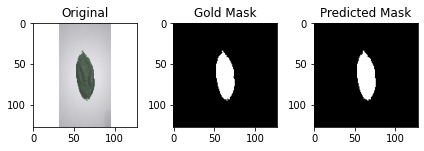

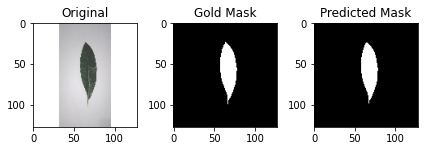

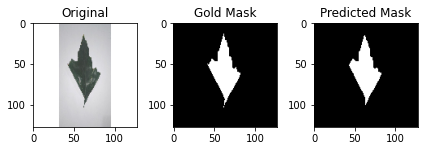

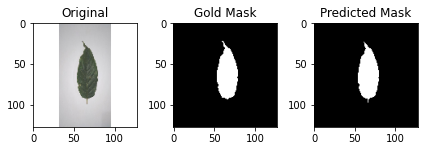

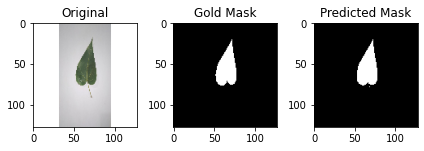

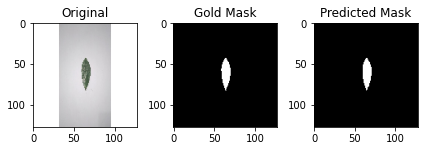

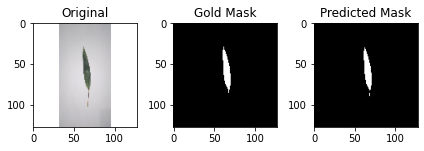

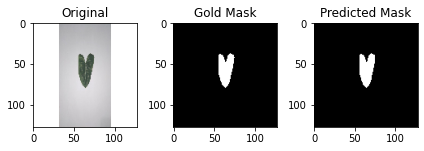

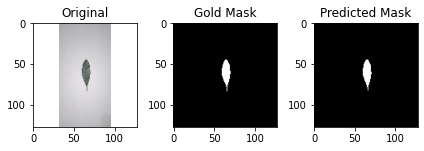

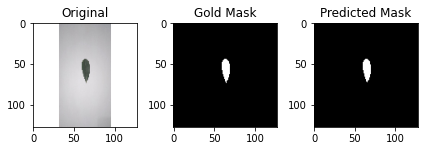

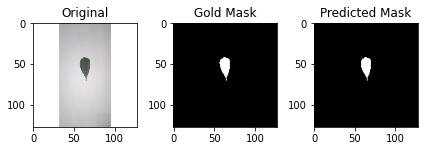

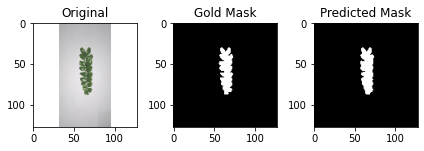

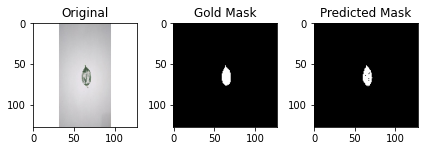

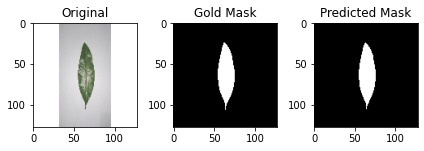

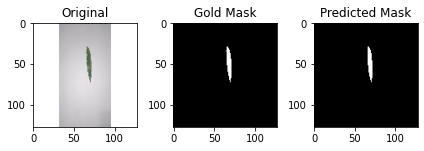

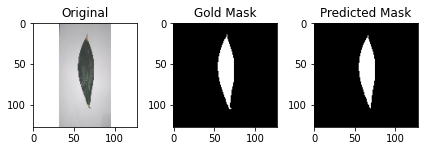

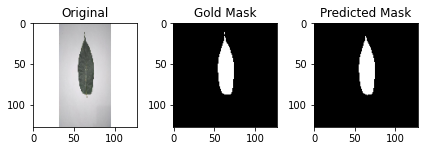

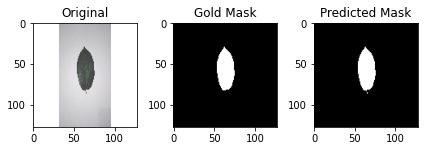

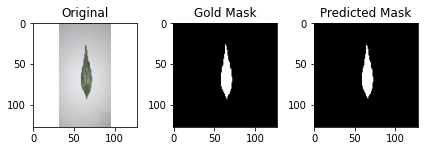

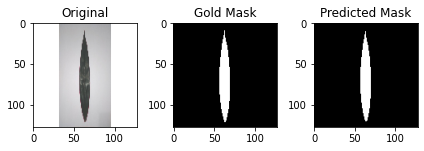

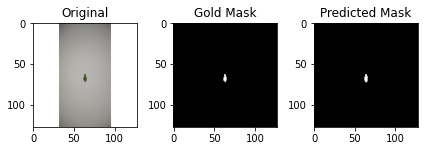

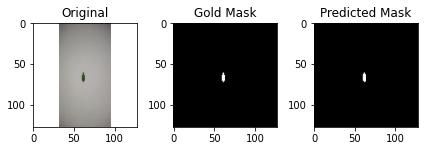

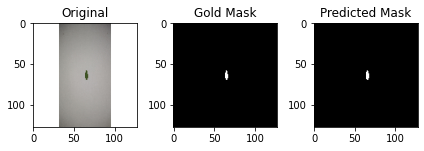

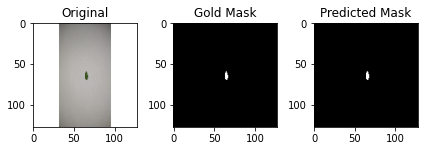

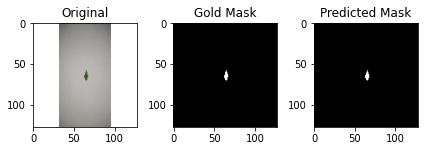

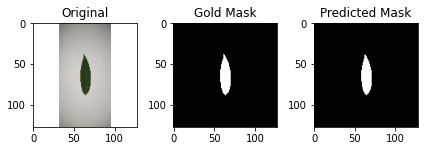

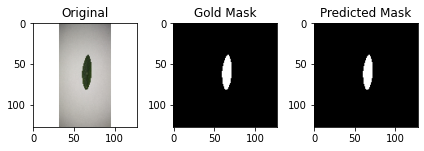

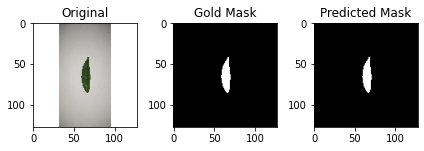

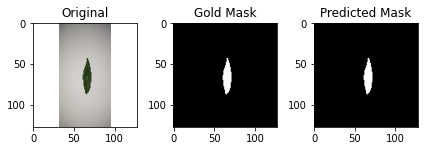

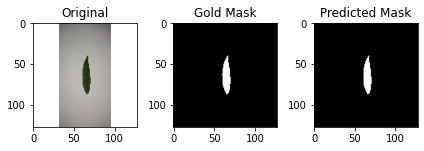

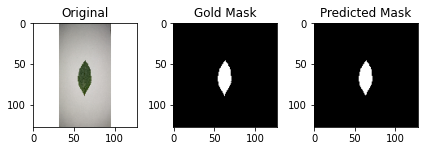

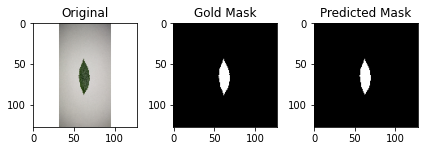

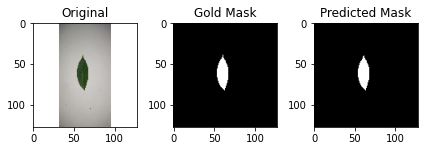

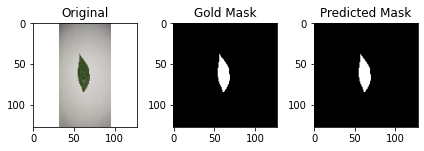

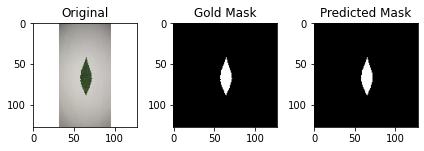

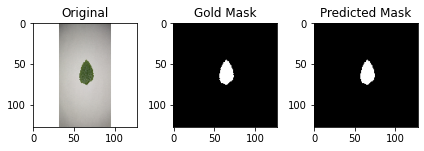

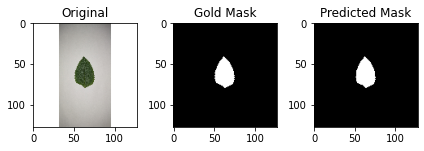

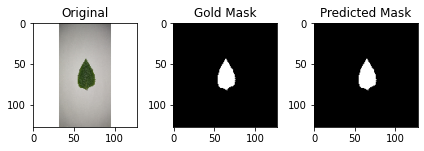

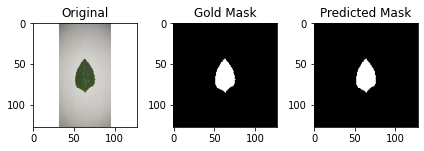

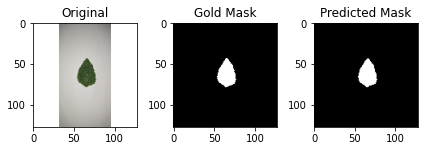

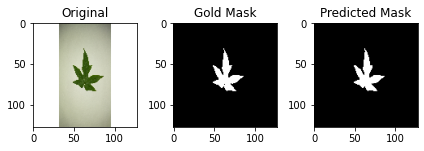

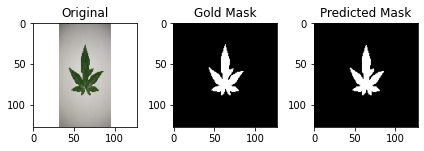

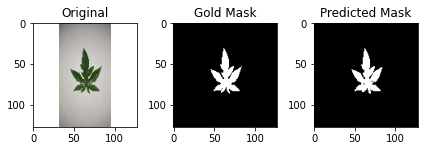

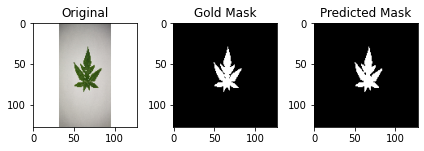

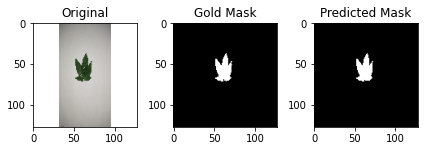

In [10]:
for i in range(len(train_predictions)):

    # making subplots
    fig, ax = plt.subplots(1, 3)

    # set data with subplots and plot  
    ax[0].imshow(X_train[i])
    ax[0].set_title('Original')
    
    ax[1].imshow(Y_train[i], cmap='gray')
    ax[1].set_title('Gold Mask')
    
    grays = rgb2gray(train_predictions[i])
    thresh = threshold_otsu( grays )    
    binary = grays > thresh

    ax[2].imshow(binary, cmap='gray')
    ax[2].set_title('Predicted Mask')

    fig.tight_layout()
    plt.show()


C:\Users\esdn6\AppData\Local\Temp\ipykernel_7944\3372928090.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2)


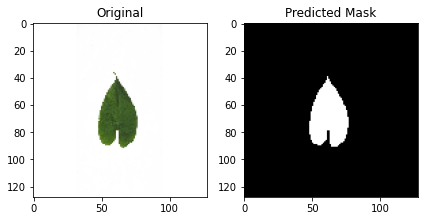

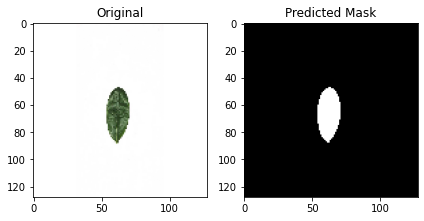

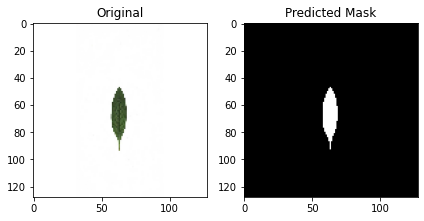

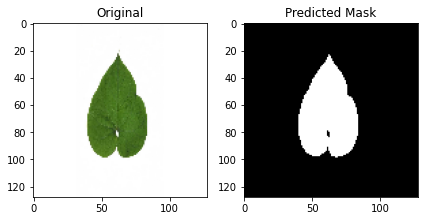

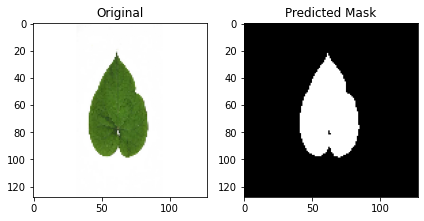

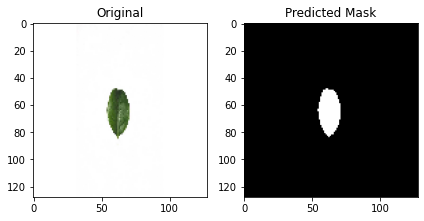

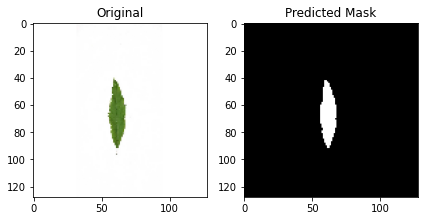

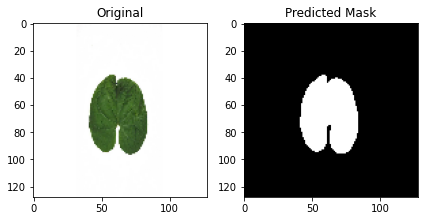

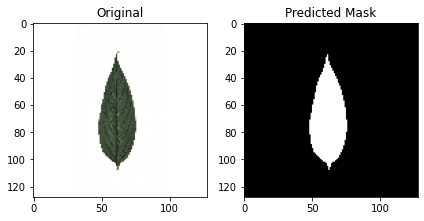

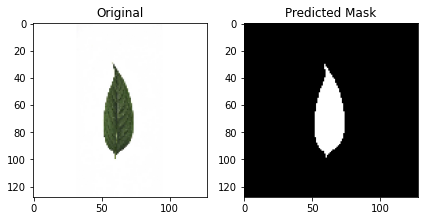

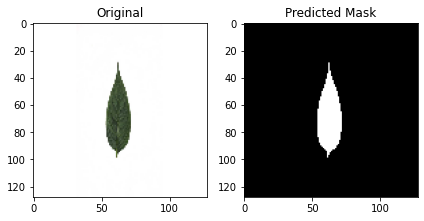

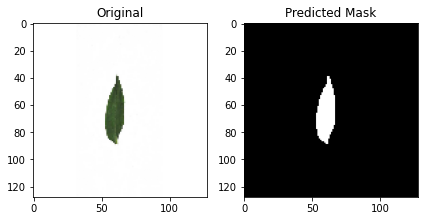

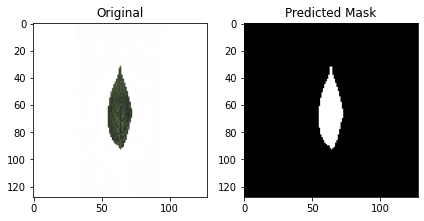

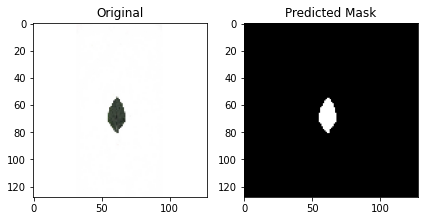

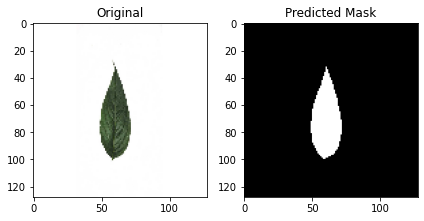

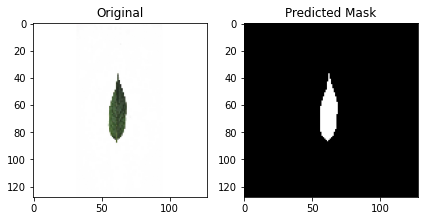

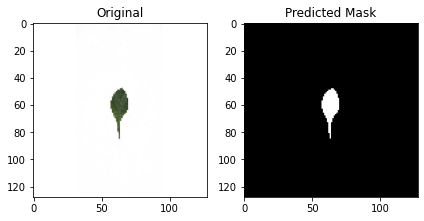

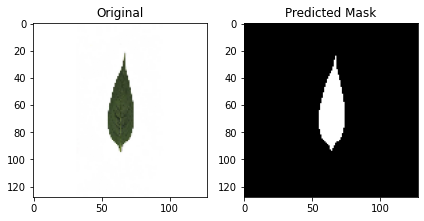

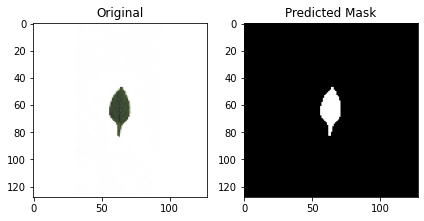

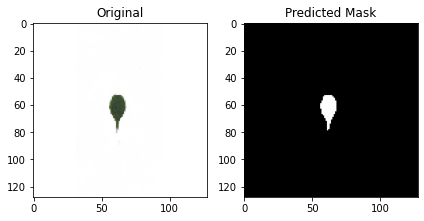

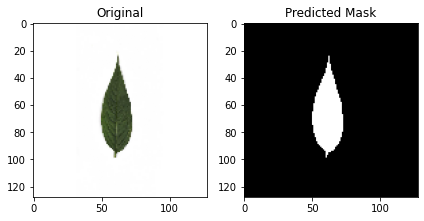

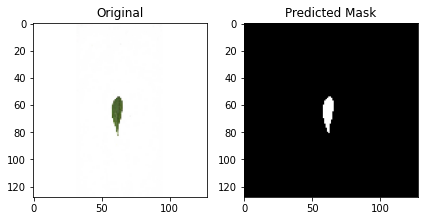

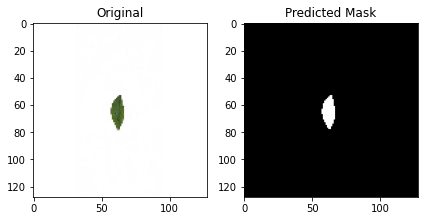

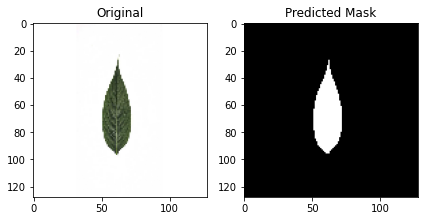

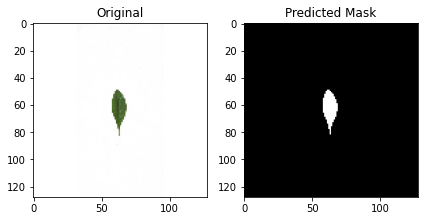

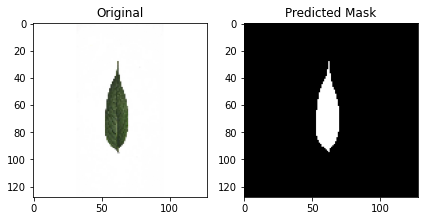

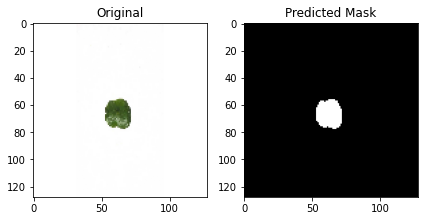

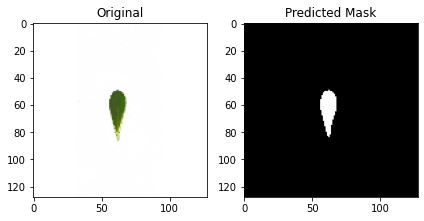

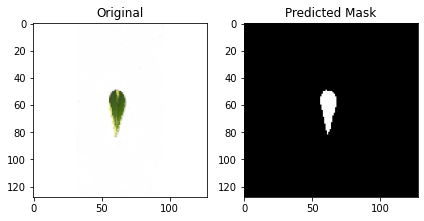

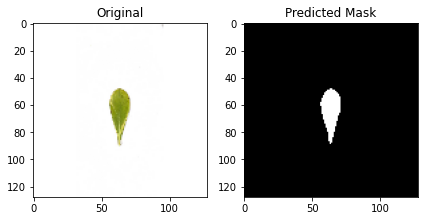

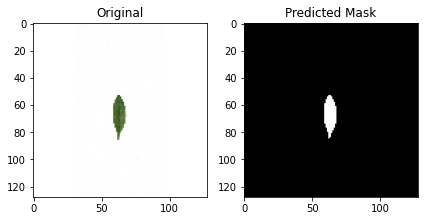

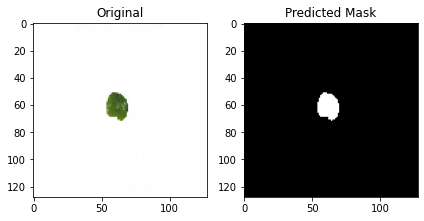

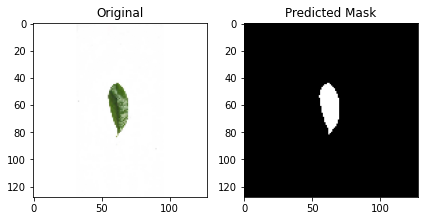

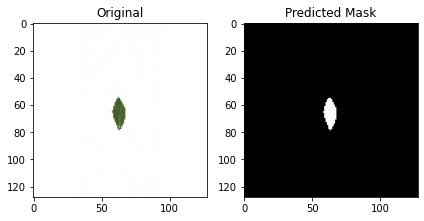

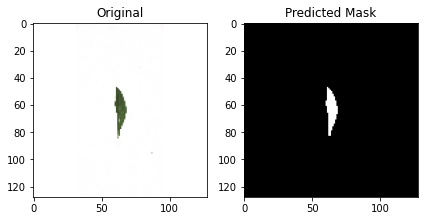

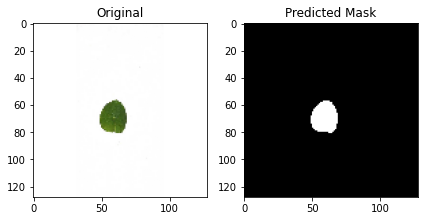

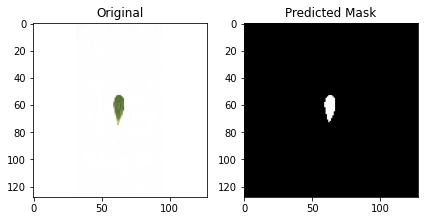

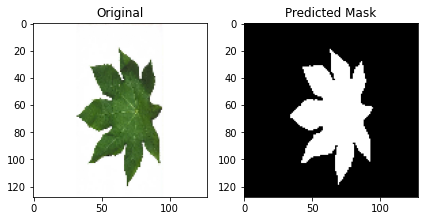

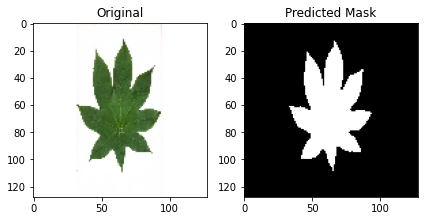

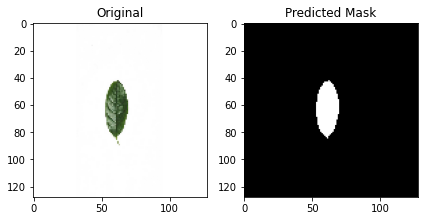

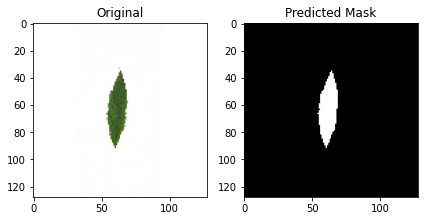

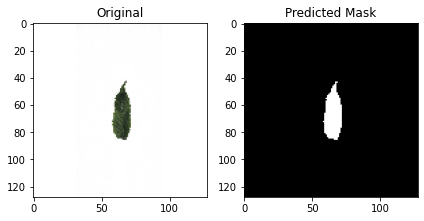

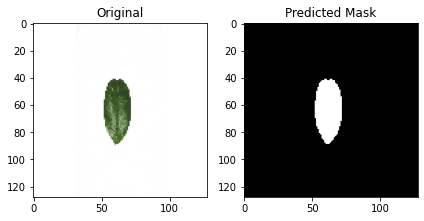

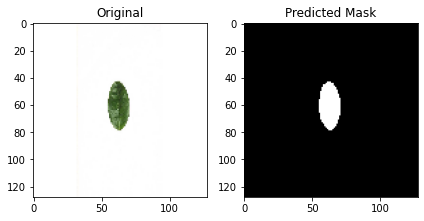

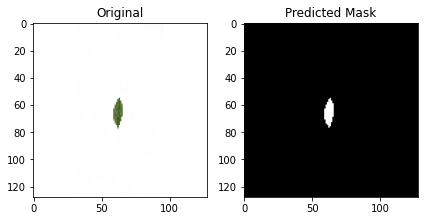

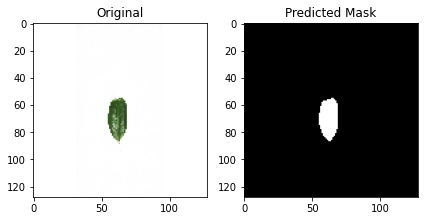

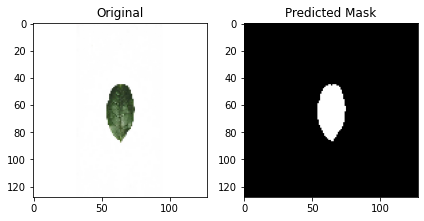

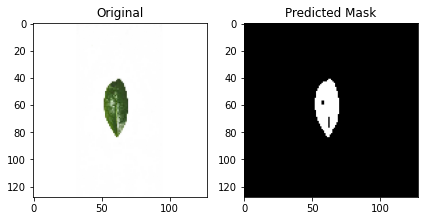

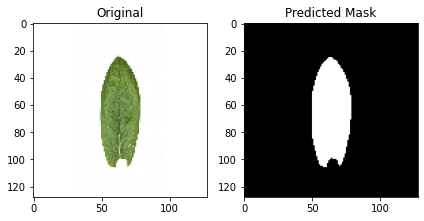

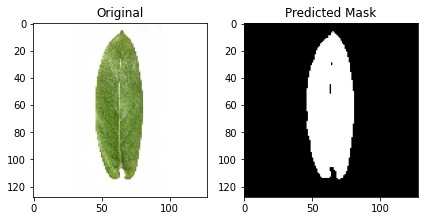

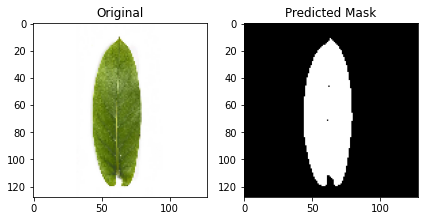

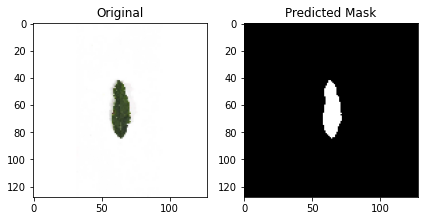

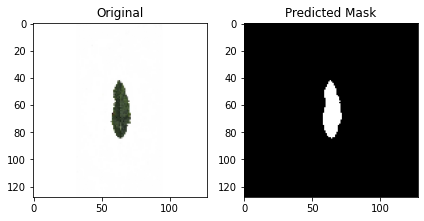

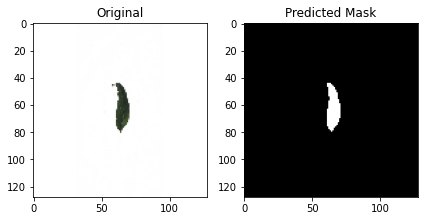

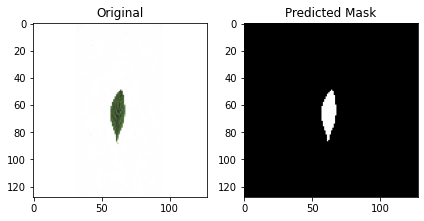

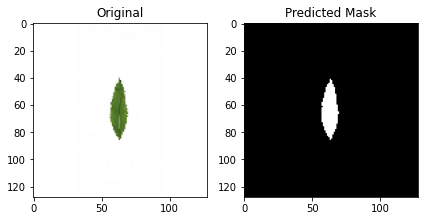

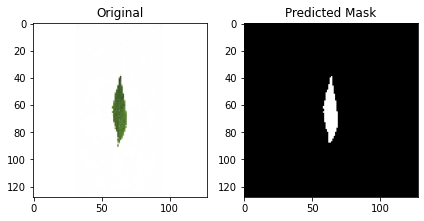

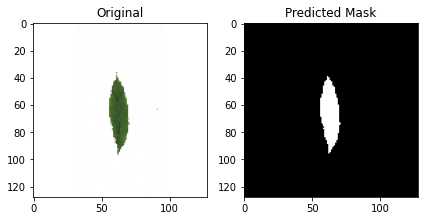

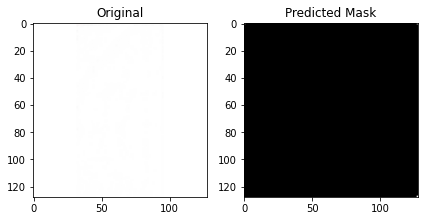

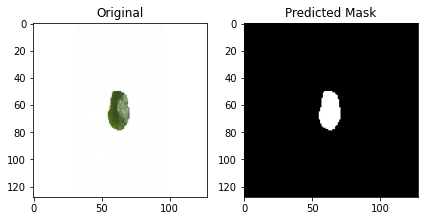

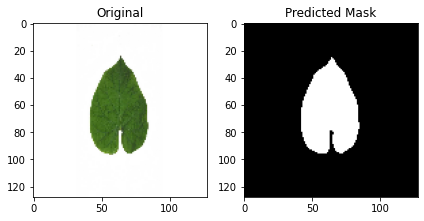

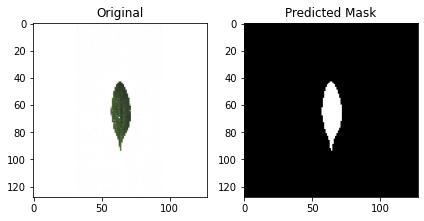

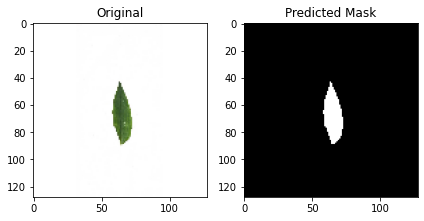

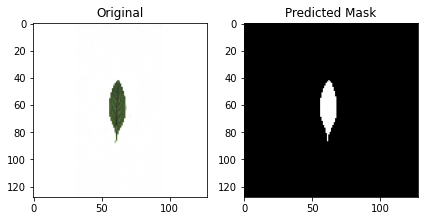

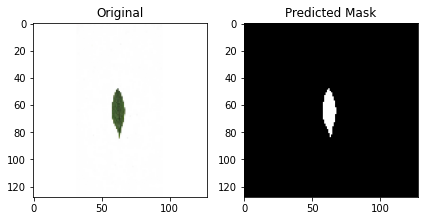

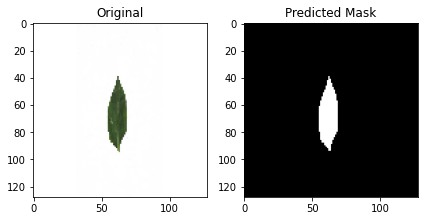

In [11]:
for i in range(len(test_predictions)):

    # making subplots
    fig, ax = plt.subplots(1, 2)

    # set data with subplots and plot  
    ax[0].imshow(X_test[i])
    ax[0].set_title('Original')
    
    grays = rgb2gray(test_predictions[i])
    thresh = threshold_otsu( grays )    
    binary = grays > thresh

    ax[1].imshow(binary, cmap='gray')
    ax[1].set_title('Predicted Mask')

    fig.tight_layout()
    #plt.show()

In [12]:
colunas = ['Original file name', 'area_em_pixels', 'altura_em_pixels', 'largura_em_pixels','IOU']
data = []

DATADIR1 = pathlib.Path(DATADIR1)
DATADIR1_files = os.listdir(DATADIR1)

DATADIR2 = pathlib.Path(DATADIR2)
DATADIR2_files = os.listdir(DATADIR2)
print(Y_train[0].shape)
print(train_predictions[i].shape)

(128, 128)


IndexError: index 65 is out of bounds for axis 0 with size 45

In [ ]:
for i in range(len(train_predictions)):
    
    grays = rgb2gray(train_predictions[i])
    thresh = threshold_otsu( grays )    
    binary = grays > thresh


    data.append(ut.take_area(X_test[i], DATADIR1_files[i]) + [ut.IOU(Y_train[i], binary)] )

df = pd.DataFrame(data=data, columns =colunas)
df

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
TESTDIR = pathlib.Path(TESTDIR)
TESTDIR_files = os.listdir(TESTDIR)